<a href="https://colab.research.google.com/github/lorrespz/Generative-models/blob/main/Flow_based_generative_model_RealNVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow-based-generative model: RealNVP

This notebook is from

https://github.com/jmtomczak/intro_dgm/blob/main/flows/realnvp_example.ipynb

with more details added.

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Dataset

In [4]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [5]:
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'realnvp'

# Utility functions

In [6]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        if hasattr(model, 'dequantization'):
            if model.dequantization:
                test_batch = test_batch + (1. - torch.rand(test_batch.shape))/2.
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss

################################################################################
def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')
    plt.show()
    #plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()
################################################################################
def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')
    plt.show()
    #plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()
################################################################################
def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.show()
    #plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

In [7]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1000.
    patience = 0
    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            if hasattr(model, 'dequantization'):
                if model.dequantization:
                    batch = batch + (1. - torch.rand(batch.shape))/2.
            loss = model.forward(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting
        #Early stopping
        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break
    nll_val = np.asarray(nll_val)
    return nll_val

# RealNVP flow model

In [8]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, num_flows, prior, D=2, dequantization=True):
        super(RealNVP, self).__init__()
        self.dequantization = dequantization
        self.prior = prior
        self.t = torch.nn.ModuleList([nett() for _ in range(num_flows)])
        self.s = torch.nn.ModuleList([nets() for _ in range(num_flows)])
        self.num_flows = num_flows

        self.D = D
    ################################################################################
    def coupling(self, x, index, forward=True):
        # x: input, either images (for the first transformation) or outputs from the previous transformation
        # index: it determines the index of the transformation
        # forward: whether it is a pass from x to y (forward=True), or from y to x (forward=False)

        (xa, xb) = torch.chunk(x, 2, 1)
        s = self.s[index](xa)
        t = self.t[index](xa)

        if forward:
            #yb = f^{-1}(x)
            yb = (xb - t) * torch.exp(-s)
        else:
            #xb = f(y)
            yb = torch.exp(s) * xb + t

        return torch.cat((xa, yb), 1), s
    ################################################################################
    def permute(self, x):
        return x.flip(1)
    ################################################################################
    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in range(self.num_flows):
            z, s = self.coupling(z, i, forward=True)
            z = self.permute(z)
            log_det_J = log_det_J - s.sum(dim=1)

        return z, log_det_J
    ################################################################################
    def f_inv(self, z):
        x = z
        for i in reversed(range(self.num_flows)):
            x = self.permute(x)
            x, _ = self.coupling(x, i, forward=False)

        return x
    ################################################################################
    def forward(self, x, reduction='avg'):
        z, log_det_J = self.f(x)
        if reduction == 'sum':
            return -(self.prior.log_prob(z) + log_det_J).sum()
        else:
            return -(self.prior.log_prob(z) + log_det_J).mean()
    ################################################################################
    def sample(self, batchSize):
        z = self.prior.sample((batchSize, self.D))
        z = z[:, 0, :]
        x = self.f_inv(z)
        return x.view(-1, self.D)

In [9]:
D = 64   # input dimension
M = 256  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3 # learning rate
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [12]:
# The number of invertible transformations
num_flows = 8
# scale (s) network
nets = lambda: nn.Sequential(nn.Linear(D // 2, M), nn.LeakyReLU(),
                             nn.Linear(M, M), nn.LeakyReLU(),
                             nn.Linear(M, D // 2), nn.Tanh())
# translation (t) network
nett = lambda: nn.Sequential(nn.Linear(D // 2, M), nn.LeakyReLU(),
                             nn.Linear(M, M), nn.LeakyReLU(),
                             nn.Linear(M, D // 2))
# Prior (a.k.a. the base distribution): Gaussian
prior = torch.distributions.MultivariateNormal(torch.zeros(D), torch.eye(D))
# Init RealNVP
model = RealNVP(nets, nett, num_flows, prior, D=D, dequantization=True)
model

RealNVP(
  (t): ModuleList(
    (0-7): 8 x Sequential(
      (0): Linear(in_features=32, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=32, bias=True)
    )
  )
  (s): ModuleList(
    (0-7): 8 x Sequential(
      (0): Linear(in_features=32, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=32, bias=True)
      (5): Tanh()
    )
  )
)

In [19]:
params = [p.numel() for p in model.parameters() if p.requires_grad]
print(f'Total numbers of parameters: {sum(params)}')

Total numbers of parameters: 1319424


# Trace the input through the model

In [20]:
for indx_batch, batch in enumerate(training_loader):
 batch0 = batch
 break


In [21]:
print('Directly pass the input through the "forward" method')

print(f'An input batch taken from the train loader has shape {batch0.shape}\n')

out = model.forward(batch0)
print(f'The output after "forward" has shape {out.shape}\n')
print(out)

Directly pass the input through the "forward" method
An input batch taken from the train loader has shape torch.Size([64, 64])

The output after "forward" has shape torch.Size([])

tensor(121.6166, grad_fn=<NegBackward0>)


In [24]:
z, log_det_J = model.f(batch0)
print(f'z shape: {z.shape}')
print(f'log_det_J shape: {log_det_J.shape}')

z shape: torch.Size([64, 64])
log_det_J shape: torch.Size([64])


In [27]:
model.prior, model.prior.log_prob

(MultivariateNormal(loc: torch.Size([64]), covariance_matrix: torch.Size([64, 64])),
 <bound method MultivariateNormal.log_prob of MultivariateNormal(loc: torch.Size([64]), covariance_matrix: torch.Size([64, 64]))>)

# Train loop

In [13]:
# OPTIMIZER
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

Epoch: 0, val nll=240.99266183035715
saved!
Epoch: 1, val nll=208.9773451450893
saved!


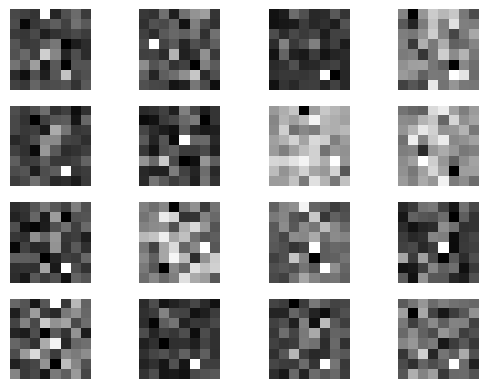

Epoch: 2, val nll=196.20095005580356
saved!


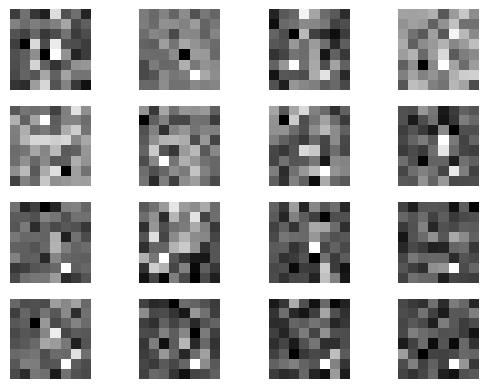

Epoch: 3, val nll=187.72076729910714
saved!


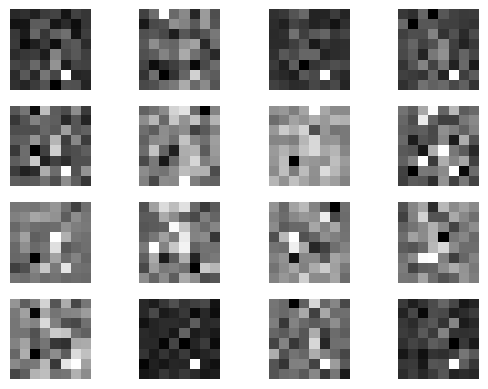

Epoch: 4, val nll=181.43546037946427
saved!


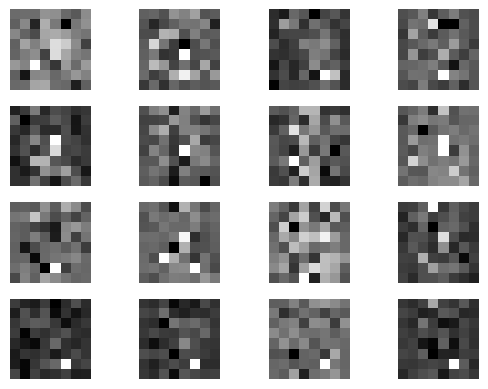

Epoch: 5, val nll=176.53439453125
saved!


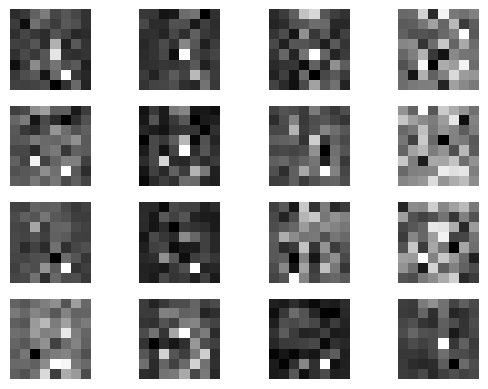

Epoch: 6, val nll=172.91023158482142
saved!


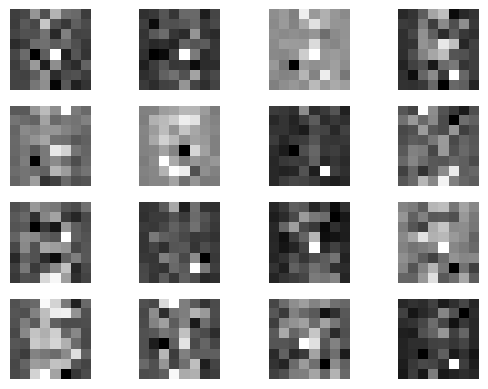

Epoch: 7, val nll=169.85759626116072
saved!


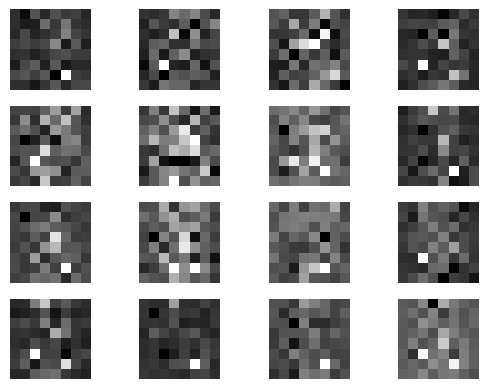

Epoch: 8, val nll=167.29867745535714
saved!


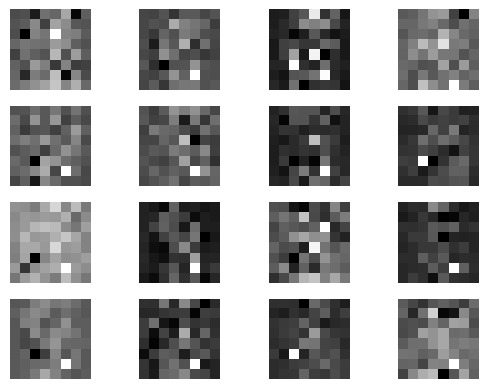

Epoch: 9, val nll=165.17117885044644
saved!


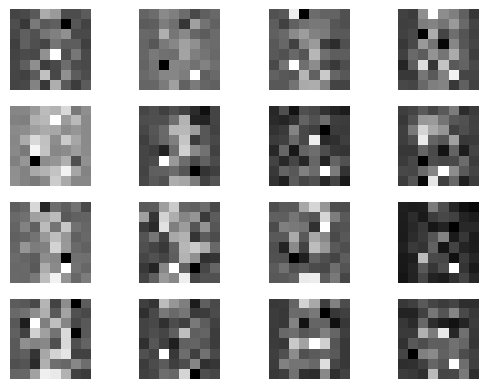

Epoch: 10, val nll=163.57716238839285
saved!


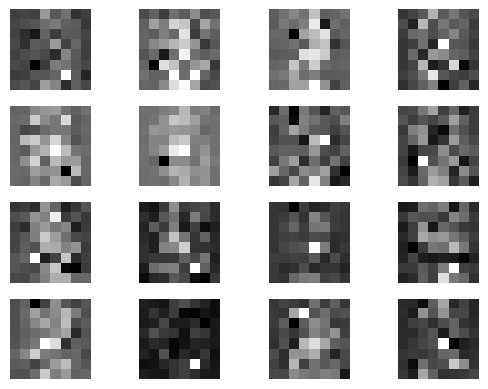

Epoch: 11, val nll=161.98013950892857
saved!


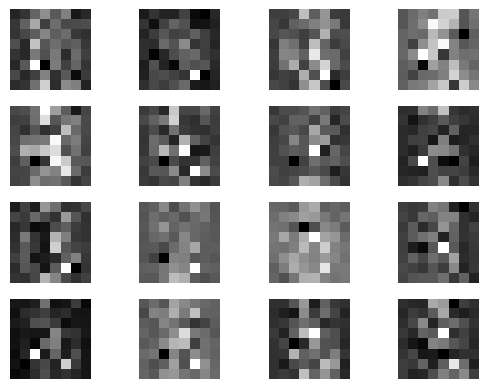

Epoch: 12, val nll=160.85804827008928
saved!


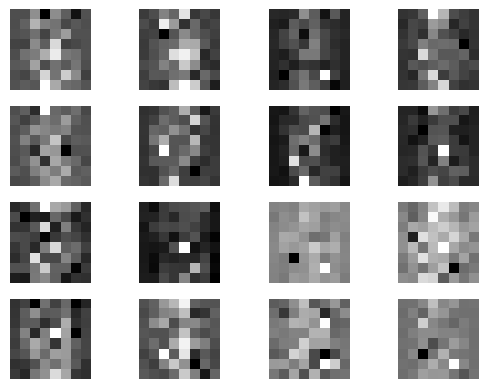

Epoch: 13, val nll=159.75574776785714
saved!


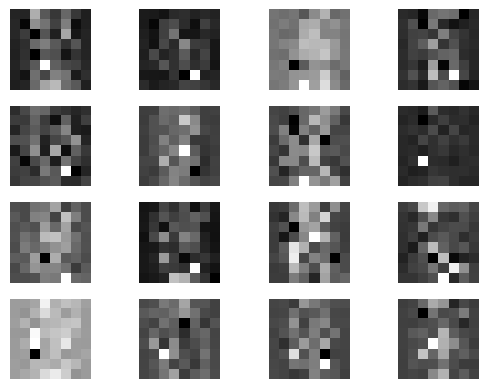

Epoch: 14, val nll=158.48863420758929
saved!


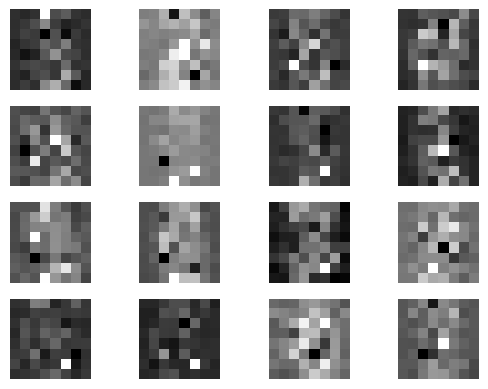

Epoch: 15, val nll=157.6496484375
saved!


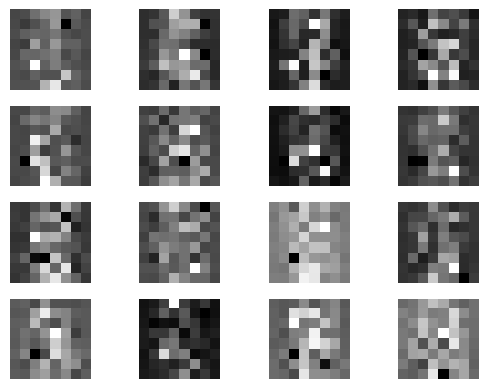

Epoch: 16, val nll=156.74565848214286
saved!


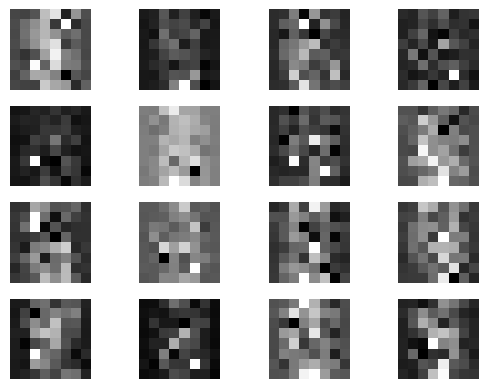

Epoch: 17, val nll=156.14386997767858
saved!


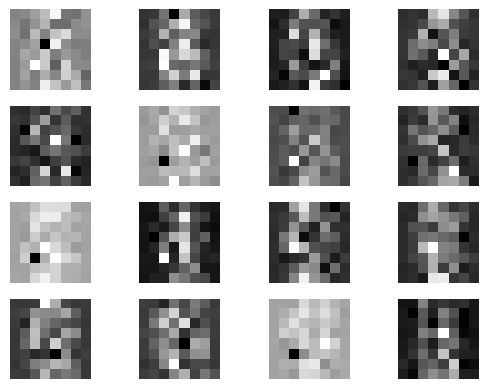

Epoch: 18, val nll=155.35643136160715
saved!


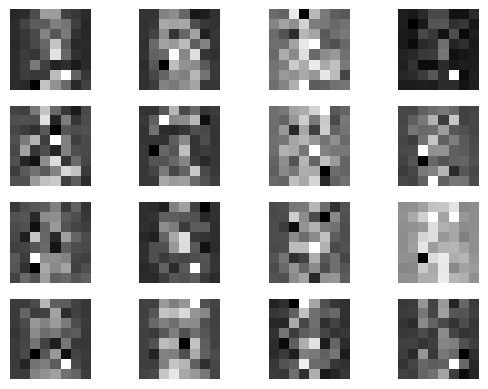

Epoch: 19, val nll=154.90752650669643
saved!


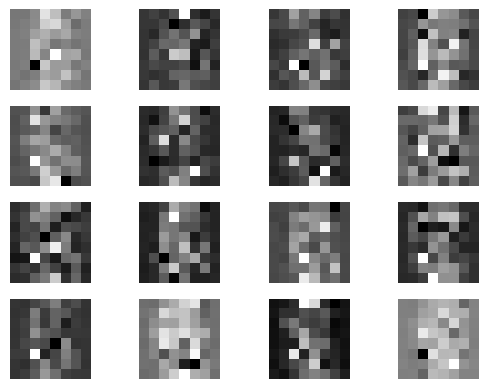

Epoch: 20, val nll=154.32661411830358
saved!


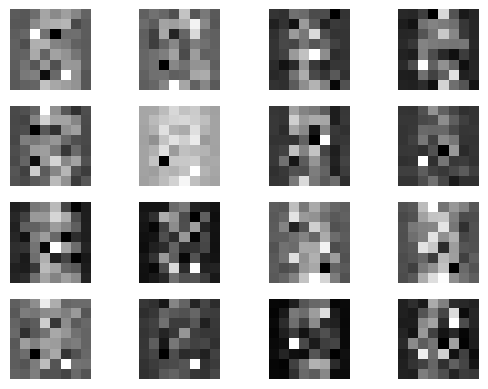

Epoch: 21, val nll=153.64838588169644
saved!


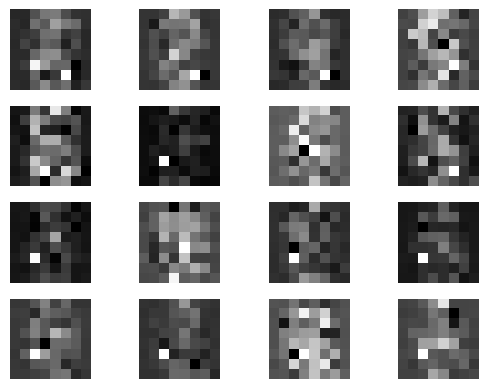

Epoch: 22, val nll=153.19945870535713
saved!


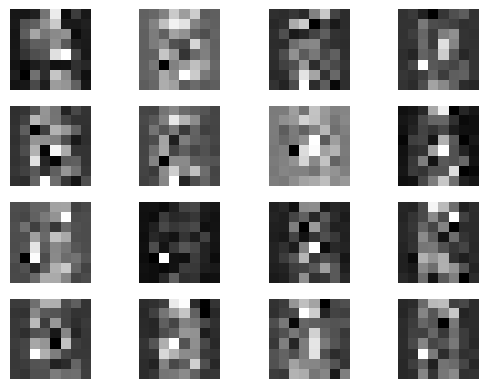

Epoch: 23, val nll=152.67969308035714
saved!


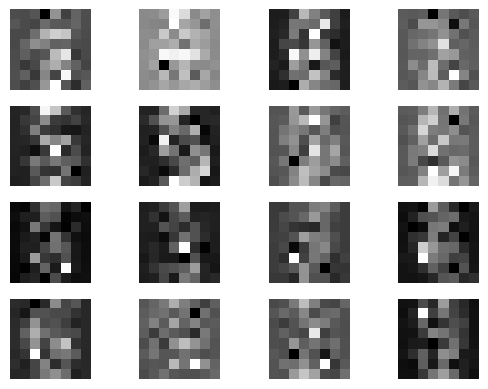

Epoch: 24, val nll=152.02243443080357
saved!


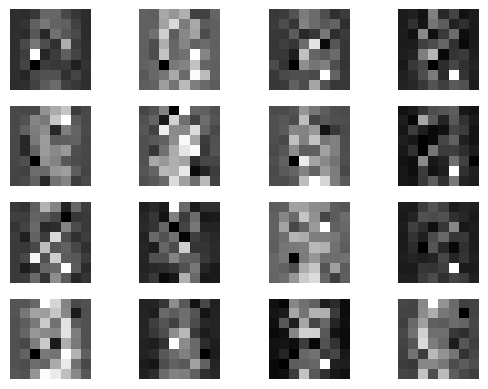

Epoch: 25, val nll=151.9566392299107
saved!


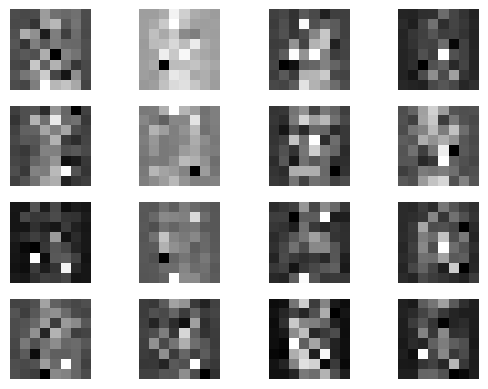

Epoch: 26, val nll=151.488046875
saved!


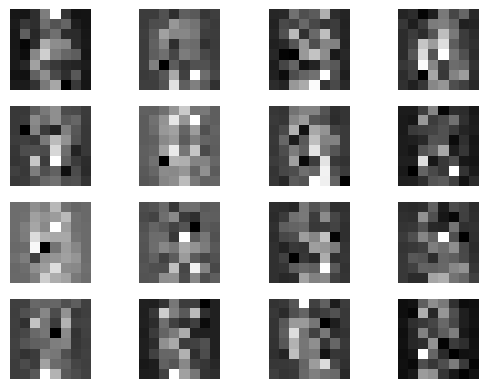

Epoch: 27, val nll=151.37439453125
saved!


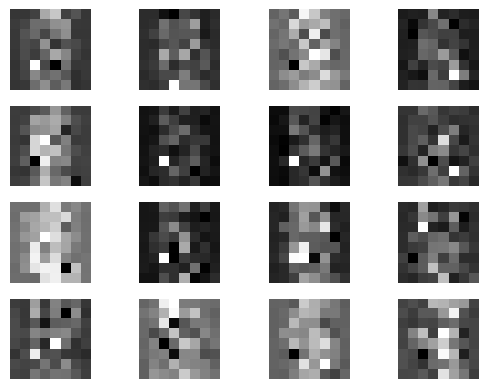

Epoch: 28, val nll=151.091533203125
saved!


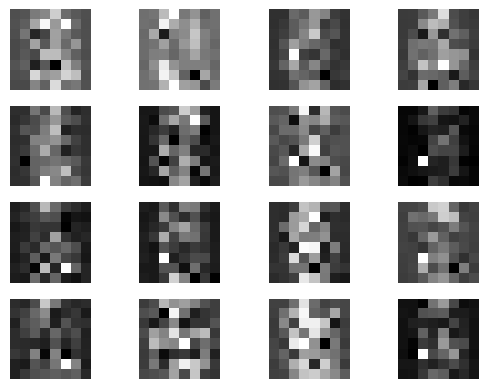

Epoch: 29, val nll=150.725078125
saved!


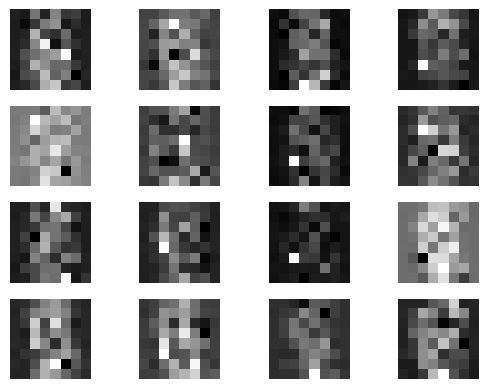

Epoch: 30, val nll=150.29627232142857
saved!


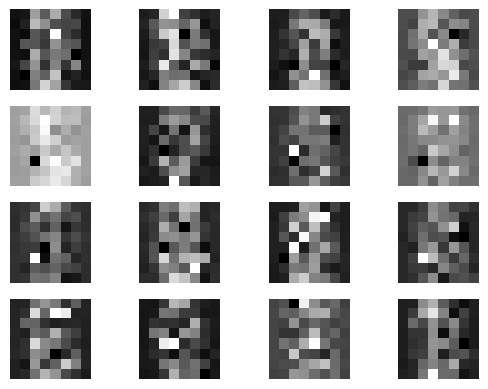

Epoch: 31, val nll=150.25233119419642
saved!


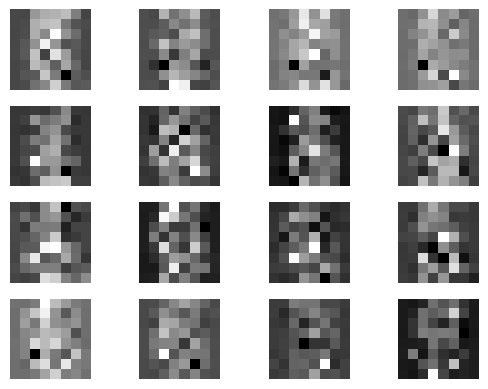

Epoch: 32, val nll=150.05349330357143
saved!


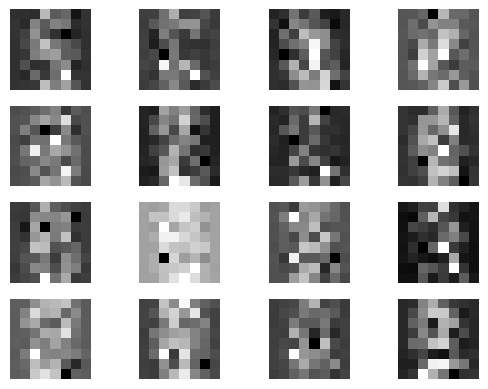

Epoch: 33, val nll=149.82949916294643
saved!


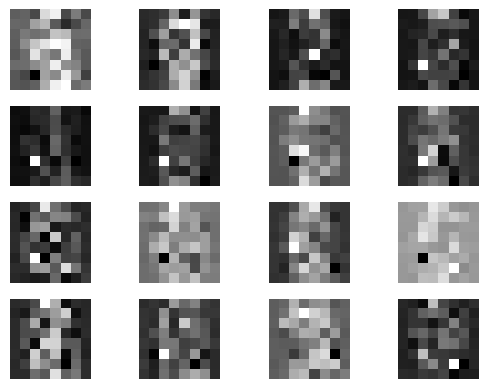

Epoch: 34, val nll=149.01288504464284
saved!


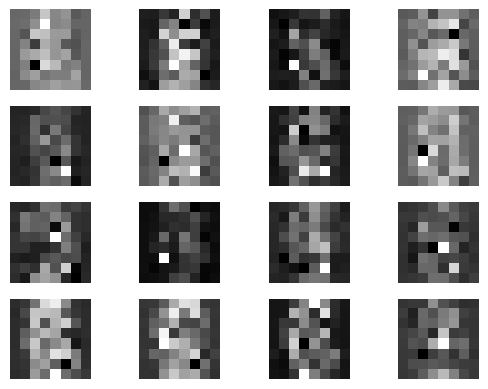

Epoch: 35, val nll=149.6826953125
Epoch: 36, val nll=149.55287667410715
Epoch: 37, val nll=149.17238002232142
Epoch: 38, val nll=148.968466796875
saved!


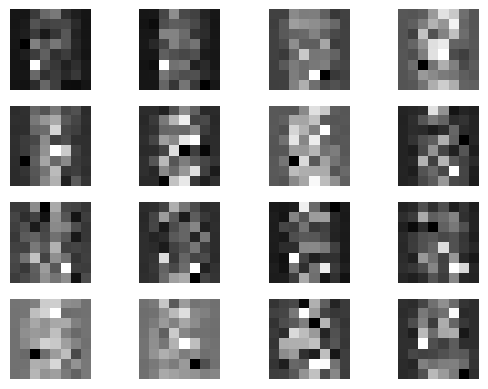

Epoch: 39, val nll=148.92421735491072
saved!


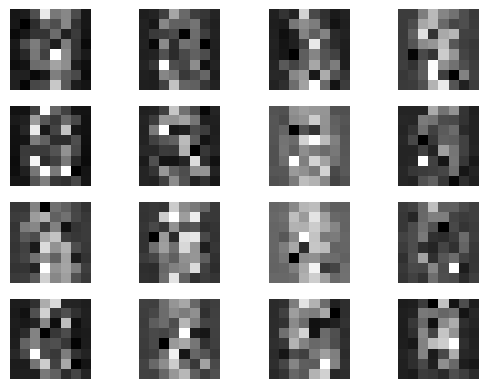

Epoch: 40, val nll=148.73593331473214
saved!


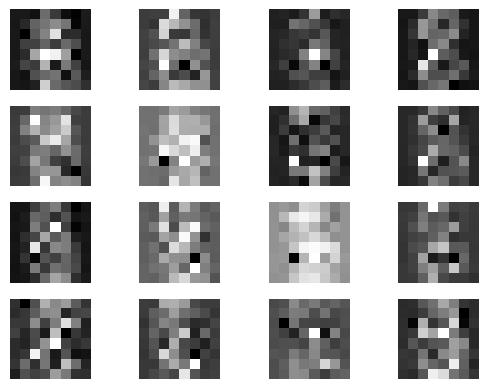

Epoch: 41, val nll=148.00933454241073
saved!


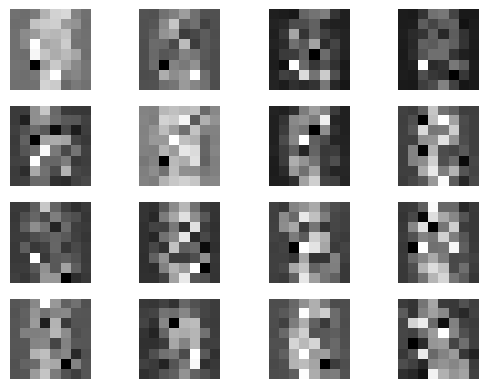

Epoch: 42, val nll=147.91119140625
saved!


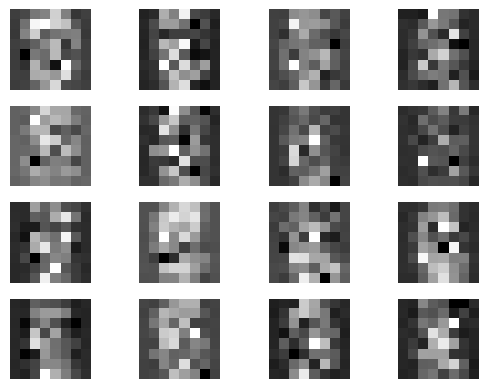

Epoch: 43, val nll=148.11537667410715
Epoch: 44, val nll=147.44009486607143
saved!


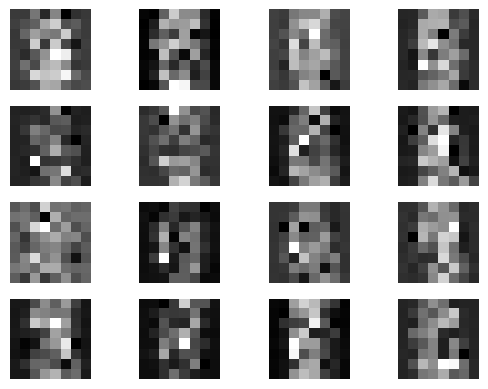

Epoch: 45, val nll=147.92655970982142
Epoch: 46, val nll=148.08488839285715
Epoch: 47, val nll=147.60243861607142
Epoch: 48, val nll=147.92534737723216
Epoch: 49, val nll=146.96122907366072
saved!


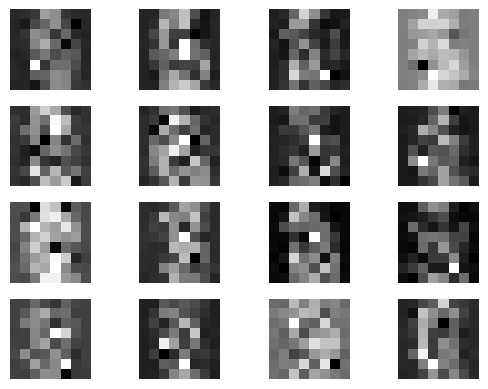

Epoch: 50, val nll=146.68633231026786
saved!


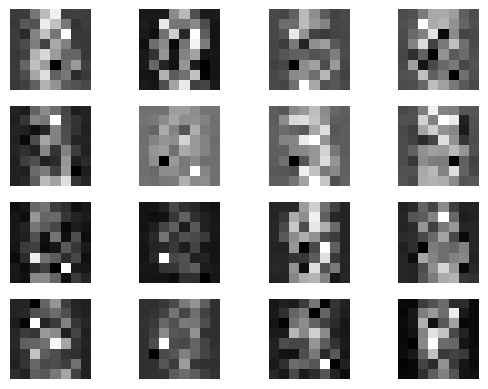

Epoch: 51, val nll=146.09439034598213
saved!


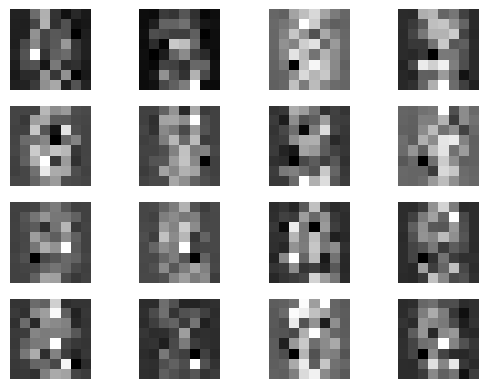

Epoch: 52, val nll=146.0728334263393
saved!


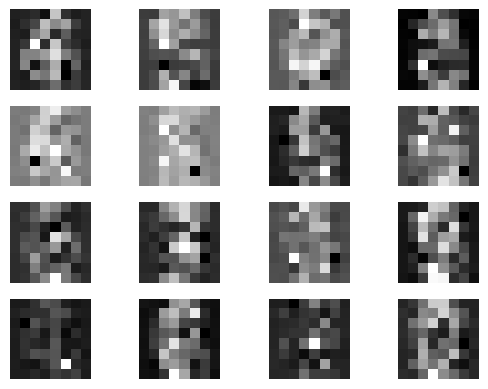

Epoch: 53, val nll=146.8191420200893
Epoch: 54, val nll=146.302099609375
Epoch: 55, val nll=145.982353515625
saved!


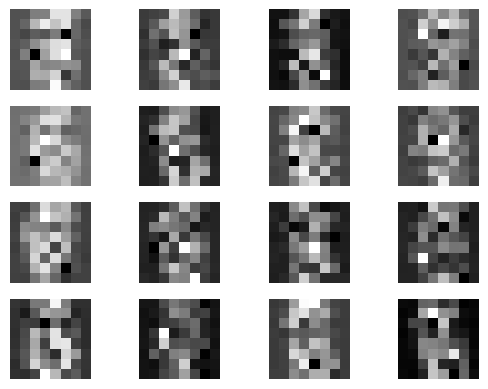

Epoch: 56, val nll=145.54360630580356
saved!


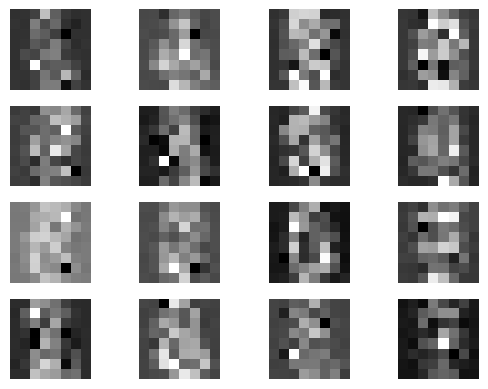

Epoch: 57, val nll=144.630107421875
saved!


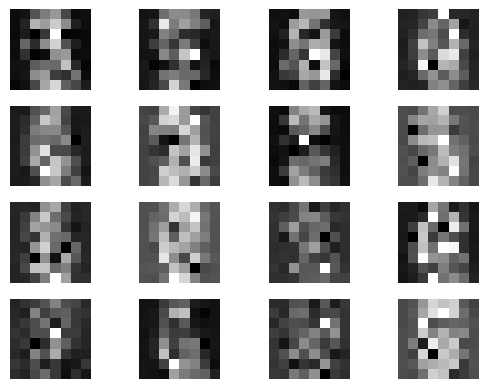

Epoch: 58, val nll=143.94196428571428
saved!


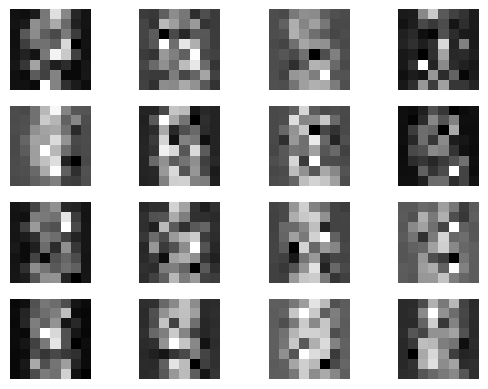

Epoch: 59, val nll=145.1252818080357
Epoch: 60, val nll=144.98250558035716
Epoch: 61, val nll=143.34278878348215
saved!


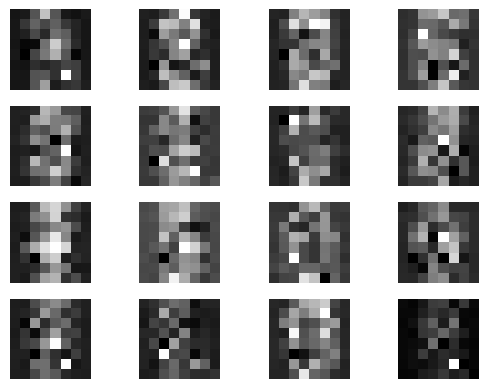

Epoch: 62, val nll=143.34498186383928
Epoch: 63, val nll=143.41640066964285
Epoch: 64, val nll=142.9744321986607
saved!


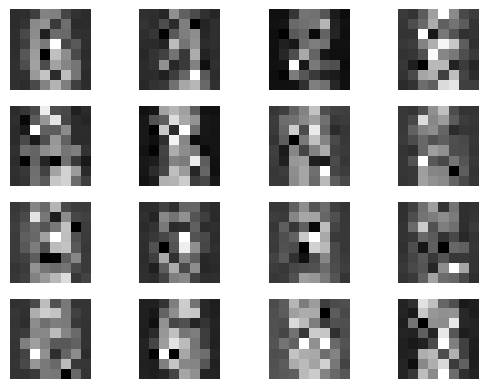

Epoch: 65, val nll=142.68763950892858
saved!


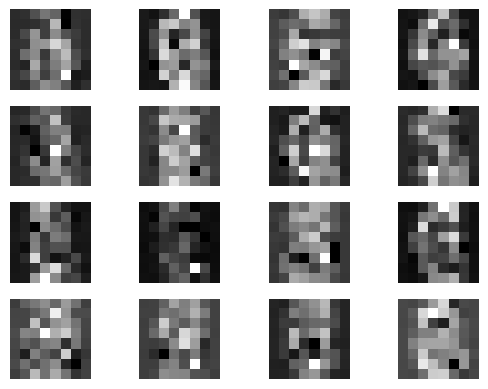

Epoch: 66, val nll=142.64103097098214
saved!


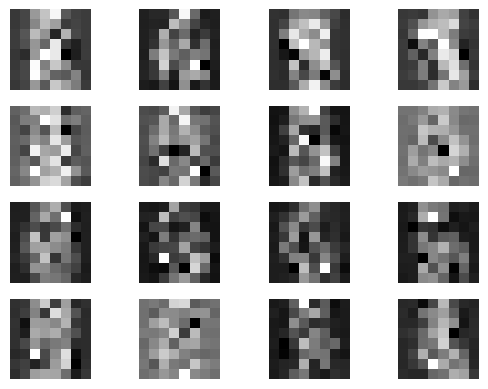

Epoch: 67, val nll=141.92489815848214
saved!


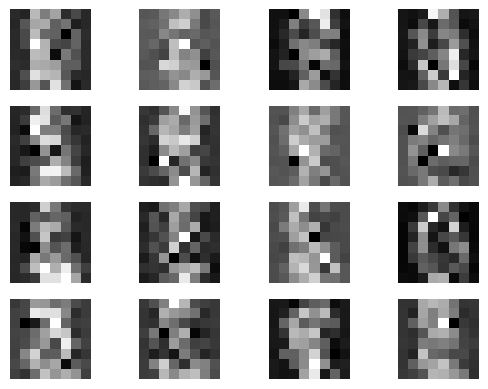

Epoch: 68, val nll=140.50782784598215
saved!


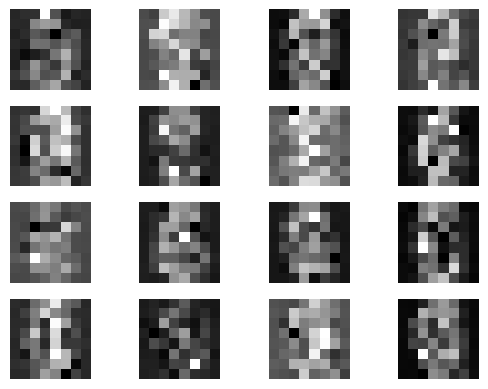

Epoch: 69, val nll=141.0702818080357
Epoch: 70, val nll=140.50988002232143
Epoch: 71, val nll=140.5805859375
Epoch: 72, val nll=141.0282421875
Epoch: 73, val nll=140.78108956473216
Epoch: 74, val nll=140.46865094866072
saved!


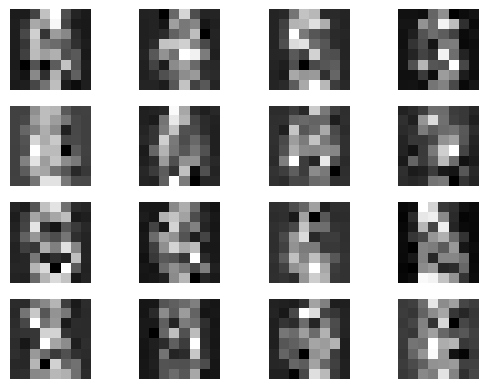

Epoch: 75, val nll=140.0480161830357
saved!


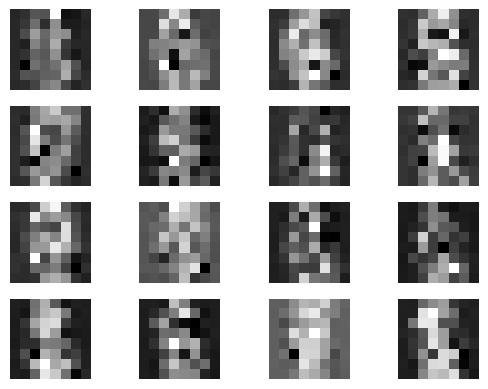

Epoch: 76, val nll=138.671240234375
saved!


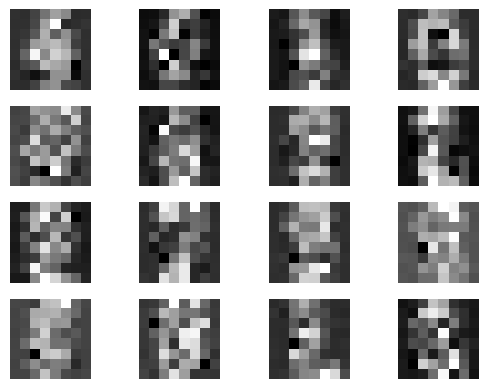

Epoch: 77, val nll=139.5320200892857
Epoch: 78, val nll=139.43429268973213
Epoch: 79, val nll=138.27882114955358
saved!


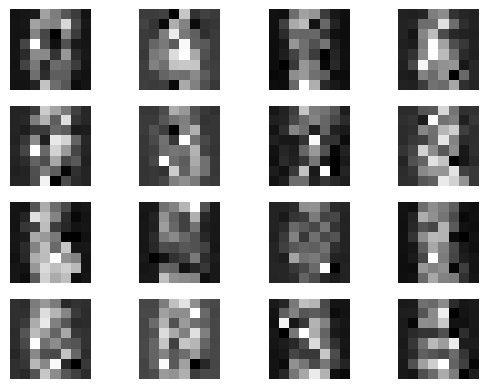

Epoch: 80, val nll=138.30289760044644
Epoch: 81, val nll=138.70224330357144
Epoch: 82, val nll=136.95357421875
saved!


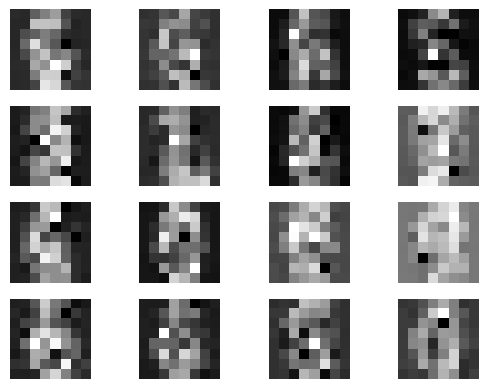

Epoch: 83, val nll=138.04286690848215
Epoch: 84, val nll=137.71351283482142
Epoch: 85, val nll=138.75577287946427
Epoch: 86, val nll=137.59185267857143
Epoch: 87, val nll=137.01046177455356
Epoch: 88, val nll=138.29595424107143
Epoch: 89, val nll=137.35465122767857
Epoch: 90, val nll=136.35972098214285
saved!


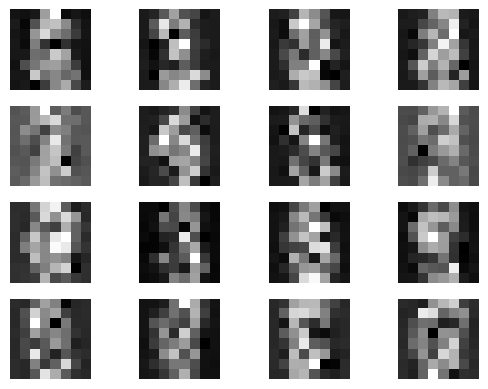

Epoch: 91, val nll=138.48478097098214
Epoch: 92, val nll=137.81055943080358
Epoch: 93, val nll=136.22643136160715
saved!


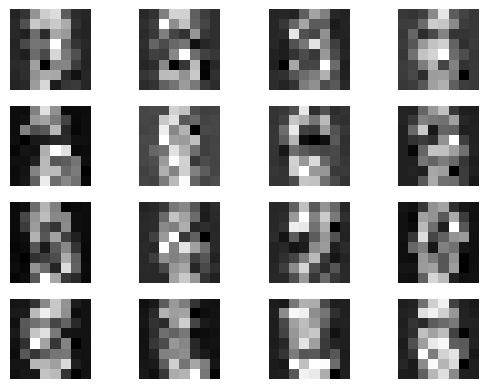

Epoch: 94, val nll=135.564755859375
saved!


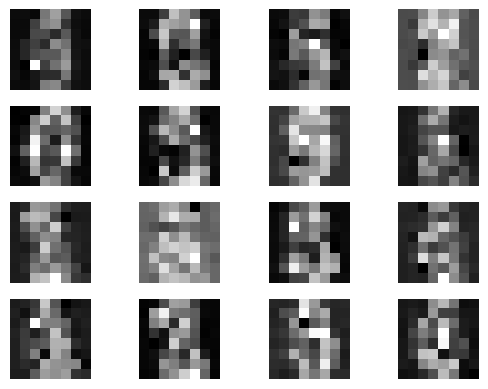

Epoch: 95, val nll=136.50468470982142
Epoch: 96, val nll=136.66655133928572
Epoch: 97, val nll=135.9569921875
Epoch: 98, val nll=136.14881975446428
Epoch: 99, val nll=135.17130859375
saved!


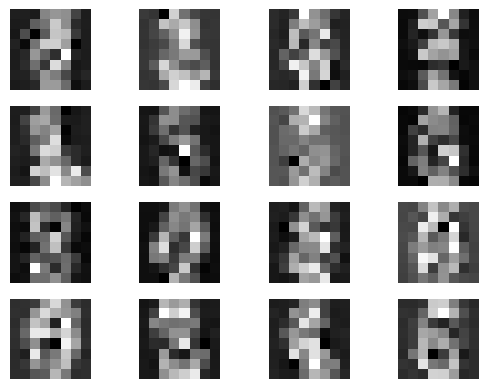

Epoch: 100, val nll=136.83274135044644
Epoch: 101, val nll=136.731337890625
Epoch: 102, val nll=135.7440443638393
Epoch: 103, val nll=134.843759765625
saved!


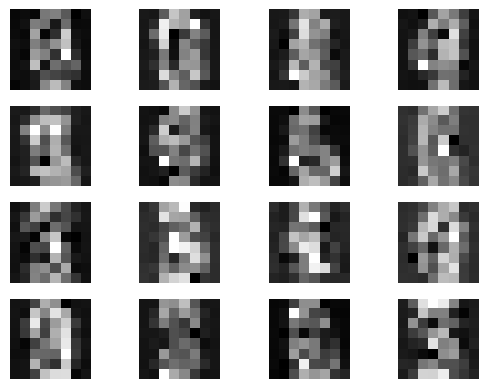

Epoch: 104, val nll=136.73781947544643
Epoch: 105, val nll=133.54982142857142
saved!


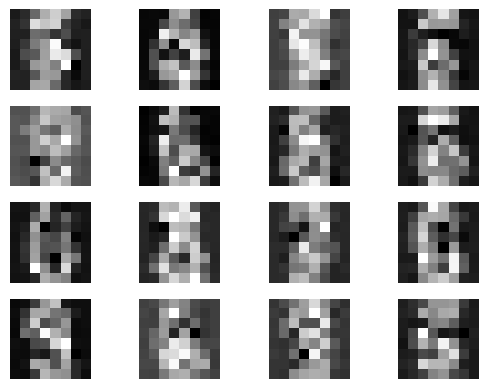

Epoch: 106, val nll=134.69441127232142
Epoch: 107, val nll=135.37916573660715
Epoch: 108, val nll=133.99157087053572
Epoch: 109, val nll=135.9804701450893
Epoch: 110, val nll=134.713486328125
Epoch: 111, val nll=134.88006138392856
Epoch: 112, val nll=135.73243303571428
Epoch: 113, val nll=134.83887974330358
Epoch: 114, val nll=133.8307896205357
Epoch: 115, val nll=135.36278599330356
Epoch: 116, val nll=136.92756556919642
Epoch: 117, val nll=135.91139927455356
Epoch: 118, val nll=135.6611635044643
Epoch: 119, val nll=132.98011021205357
saved!


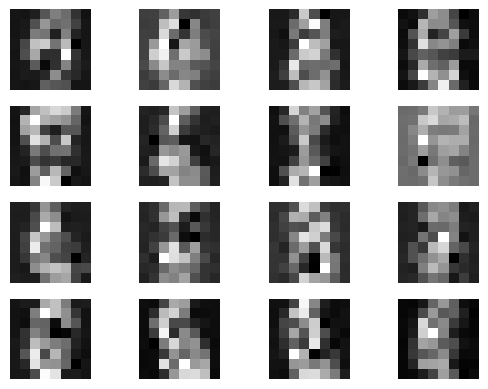

Epoch: 120, val nll=134.73537527901786
Epoch: 121, val nll=136.21888532366071
Epoch: 122, val nll=134.85363002232143
Epoch: 123, val nll=133.55198660714285
Epoch: 124, val nll=134.55602399553572
Epoch: 125, val nll=134.78553013392857
Epoch: 126, val nll=135.28990513392858
Epoch: 127, val nll=133.490107421875
Epoch: 128, val nll=135.8780482700893
Epoch: 129, val nll=133.96424525669642
Epoch: 130, val nll=134.407978515625
Epoch: 131, val nll=137.373818359375
Epoch: 132, val nll=137.03237165178572
Epoch: 133, val nll=136.95093191964287
Epoch: 134, val nll=133.84898577008929
Epoch: 135, val nll=134.65948521205357
Epoch: 136, val nll=136.6285435267857
Epoch: 137, val nll=136.91872349330356
Epoch: 138, val nll=137.35589983258927
Epoch: 139, val nll=135.709609375
Epoch: 140, val nll=135.97376395089285


In [14]:
# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                       training_loader=training_loader, val_loader=val_loader)

In [15]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)

FINAL LOSS: nll=118.7029666089905


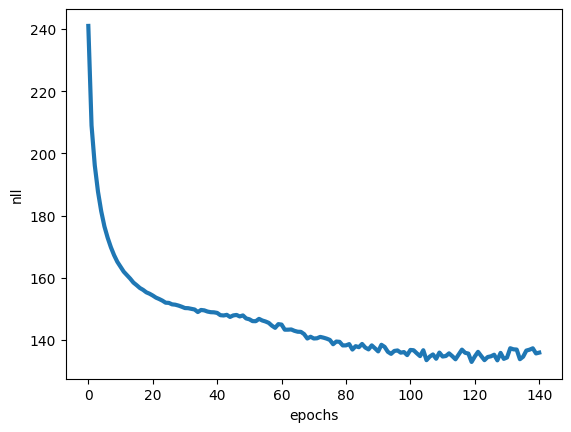

In [16]:
#samples_real(result_dir + name, test_loader)

plot_curve(name, nll_val)